<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/tinyVGG_cnn_binary_classification_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Build and train the TinyVGG CNN model
1. Import statements
1. Get Food101 data
2. Create a function to display a image and some details like shape
3. Split the data into training and test set
4. Create `tf.data.Dataset` using `tf.keras.preprocessing`
5. Build data augmentation layer
6. Build the model using Tensorflow Seqential API
7. Compile the model
6. Create function to plot the loss curve
8. Create callbacks
  1. Tensorboard
  2. EarlyStopping
  3. Model Checkpoint
  4. ReduceLR
9. Fit the model
10. Save the model in .h5 format
11. Load a saved checkpoint
12. Evaluate the model


In [1]:
# import cell
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import datetime
import random
import zipfile
import os

print(f" Tensorflow version : {tf.__version__}")

 Tensorflow version : 2.12.0


In [2]:
# Download data and unzip the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

zipref= zipfile.ZipFile("/content/pizza_steak.zip")
zipref.extractall()
zipref.close()
os.remove("/content/pizza_steak.zip")


--2023-08-12 18:31:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   154MB/s    in 0.7s    

2023-08-12 18:31:34 (154 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [3]:
for dirpath,dirnames,filenames in os.walk("/content/pizza_steak"):
  print(f" There are {len(filenames)} files and {len(dirnames)} directories at {dirpath}")

 There are 0 files and 2 directories at /content/pizza_steak
 There are 0 files and 2 directories at /content/pizza_steak/test
 There are 250 files and 0 directories at /content/pizza_steak/test/steak
 There are 250 files and 0 directories at /content/pizza_steak/test/pizza
 There are 0 files and 2 directories at /content/pizza_steak/train
 There are 750 files and 0 directories at /content/pizza_steak/train/steak
 There are 750 files and 0 directories at /content/pizza_steak/train/pizza


In [4]:
# define the train and test directory
train_dir= "/content/pizza_steak/train"
test_dir= "/content/pizza_steak/test"

# Define the image height and width
IMAGE_SIZE=(224,224)

In [5]:
# Function View a random image
def view_random_image(train_dir, test_dir,target_class):
  """
   Takes the train and test directory and displays a random image
   from each directory
  """
  target_train_dir= train_dir + "/" + target_class
  target_test_dir= test_dir+ "/" + target_class
  random_train_img_fname = random.sample(os.listdir(target_train_dir),1)
  random_test_img_fname= random.sample(os.listdir(target_test_dir),1)
  random_train_img = mpimg.imread(target_train_dir+ "/" + random_train_img_fname[0])
  random_test_img = mpimg.imread(target_test_dir+ "/" + random_test_img_fname[0])

  gs= gridspec.GridSpec(1,2)

  plt.figure(figsize=(10,7))

  ax= plt.subplot(gs[0,0])
  plt.title(random_train_img_fname)
  plt.imshow(random_train_img)
  plt.axis(False)

  ax= plt.subplot(gs[0,1])
  plt.title(random_test_img_fname)
  plt.imshow(random_test_img)
  plt.axis(False)

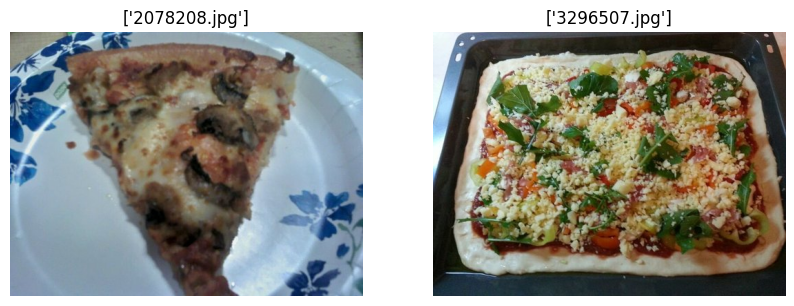

In [6]:
view_random_image(train_dir,test_dir,"pizza")

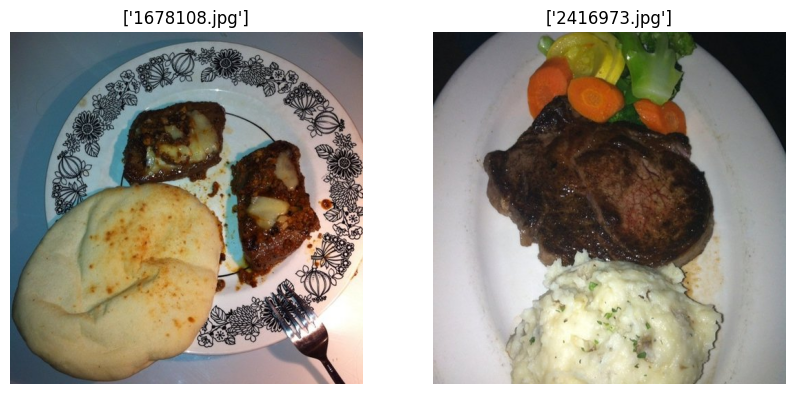

In [7]:
view_random_image(train_dir,test_dir,"steak")

In [8]:
train_dataset= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir
                                                                   ,labels="inferred"
                                                                   ,label_mode="binary"
                                                                   ,image_size=IMAGE_SIZE
                                                                   ,shuffle=True
                                                                   )
test_dataset= tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir
                                                                   ,labels="inferred"
                                                                   ,label_mode="binary"
                                                                   ,image_size=IMAGE_SIZE
                                                                   ,shuffle=True
                                                                  )


Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [9]:
class_names= train_dataset.class_names
class_names

['pizza', 'steak']

In [10]:
train_dataset= train_dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset= test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
def plot_loss_curve(history):
  """
    Plots the loss and accuracy for train and test data
  """

  epochs= range(len(history.history["loss"]))
  loss= history.history["loss"]
  val_loss= history.history["val_loss"]

  accuracy= history.history["accuracy"]
  val_accuracy= history.history["val_accuracy"]

  plt.figure()
  plt.plot(epochs,loss,label="Train")
  plt.plot(epochs,val_loss,label="Test")
  plt.xlabel("Epochs")
  plt.title("Loss")
  plt.legend()

  plt.figure()
  plt.plot(epochs,accuracy,label="Train")
  plt.plot(epochs,val_accuracy,label="Test")
  plt.xlabel("Epochs")
  plt.title("Accuracy")
  plt.legend()




In [13]:
# create callbacks
# 7. Create early stopping, model checkpoint ,ReduceLROnPlateau tensorboard callbacks.
def create_tensorboard_callback(log_dir,experiment_name):
  log_dir= log_dir + "/" + experiment_name + "/"+datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
  print(f" Saving tensorboard logs to : {log_dir}")
  return tf.keras.callbacks.TensorBoard(log_dir)

def create_model_checkpoint(model_checkpoint_dir):
  model_checkpoint_path=f"{model_checkpoint_dir}/cp.ckpt"
  return tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path
                                            ,monitor="val_accuracy"
                                            ,save_best_only=True
                                            ,save_weights_only=True
                                            ,verbose=0)

def create_early_stopping():
  return tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                          patience=3)

def create_learningrate_reducer():
  return tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss"
                                              ,patience=2
                                              ,factor=0.01
                                              ,verbose=1 # Print when the learning rate goes down
                                              ,min_lr=1e-7)

In [15]:
data_augmentation= tf.keras.Sequential([
     layers.Rescaling(scale=1./255)
    ,layers.RandomFlip(mode="horizontal")
    ,layers.RandomHeight(factor=0.2)
    ,layers.RandomWidth(factor=0.2)
])

In [23]:
# Build the model using Sequential API

tinyVGG_model= tf.keras.Sequential([
    data_augmentation
    # Block 1
    ,layers.Conv2D(filters=10
                   ,kernel_size=3
                   ,strides=1
                   ,padding="valid"
                   ,input_shape=(224,224,3))
    ,layers.Activation(activation="relu")
    # block2
    ,layers.BatchNormalization()
    ,layers.Conv2D(filters=10,kernel_size=3)
    ,layers.Activation(activation="relu")
    ,layers.MaxPool2D()
    # block 3
    ,layers.BatchNormalization()
    ,layers.Conv2D(filters=10,kernel_size=3)
    ,layers.Activation(activation="relu")
    # block 4
    ,layers.BatchNormalization()
    ,layers.Conv2D(filters=10,kernel_size=3)
    ,layers.Activation(activation="relu")
    ,layers.MaxPool2D()
    # output layer
    ,layers.GlobalMaxPool2D()
    ,layers.Dense(1,activation="sigmoid")
])

# compile the model
tinyVGG_model.compile(loss=tf.keras.losses.binary_crossentropy
                      ,optimizer=tf.keras.optimizers.Adam()
                      ,metrics=["accuracy"])


In [24]:
history_1= tinyVGG_model.fit(train_dataset
                  ,steps_per_epoch=len(train_dataset)
                  ,validation_data= test_dataset
                  ,validation_steps=len(test_dataset)
                  ,epochs=5
                  ,callbacks=[
                      create_tensorboard_callback(log_dir="tensorboard_logs",experiment_name="tinyvgg")
                      ,create_model_checkpoint(model_checkpoint_dir="model_ckpt")
                      ,create_early_stopping()
                      ,create_learningrate_reducer()
                  ])

 Saving tensorboard logs to : tensorboard_logs/tinyvgg/20230812_185626
Epoch 1/5
47/47 [==============================] - 166s 3s/step - loss: 1.4847 - accuracy: 0.5433 - val_loss: 0.6947 - val_accuracy: 0.4780 - lr: 0.0010
Epoch 2/5
47/47 [==============================] - 140s 3s/step - loss: 0.5970 - accuracy: 0.6787 - val_loss: 0.6897 - val_accuracy: 0.5020 - lr: 0.0010
Epoch 3/5
47/47 [==============================] - 156s 3s/step - loss: 0.5450 - accuracy: 0.7333 - val_loss: 0.7145 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/5
47/47 [==============================] - ETA: 0s - loss: 0.5259 - accuracy: 0.7480
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
47/47 [==============================] - 160s 3s/step - loss: 0.5259 - accuracy: 0.7480 - val_loss: 0.7000 - val_accuracy: 0.5160 - lr: 0.0010
Epoch 5/5
47/47 [==============================] - 153s 3s/step - loss: 0.5043 - accuracy: 0.7647 - val_loss: 0.6808 - val_accuracy: 0.5380 - lr: 1.0000e-05


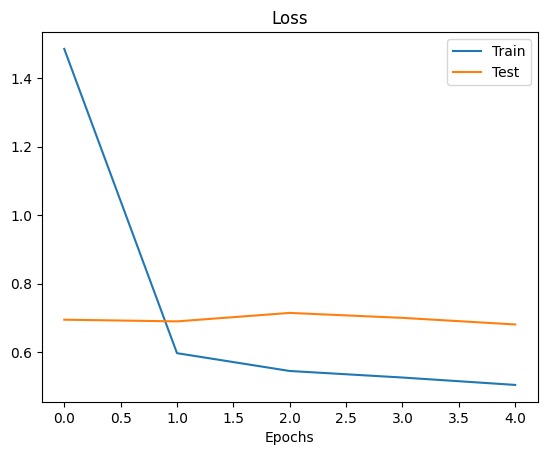

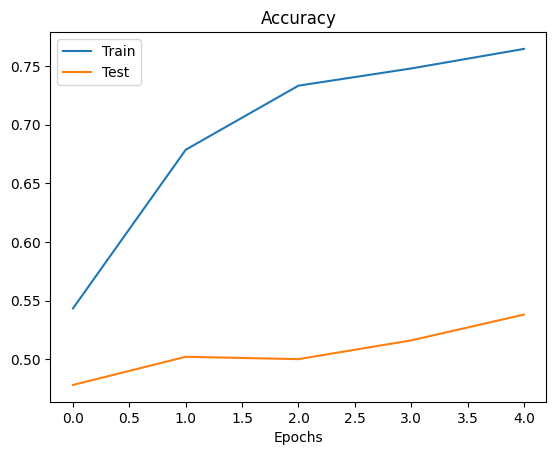

In [33]:
plot_loss_curve(history_1)

In [34]:
tinyVGG_model.evaluate(test_dataset)

16/16 [==============================] - 15s 792ms/step - loss: 0.6808 - accuracy: 0.5380


[0.6807552576065063, 0.5379999876022339]

In [35]:
tinyVGG_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 10)    280       
                                                                 
 activation_8 (Activation)   (None, None, None, 10)    0         
                                                                 
 batch_normalization_6 (Batc  (None, None, None, 10)   40        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 10)    910       
                                                                 
 activation_9 (Activation)   (None, None, None, 10)    0         
                                                      

In [36]:
# save model in .h5 format
tinyVGG_model.save("tinyVGG.h5")

In [37]:
# load saved model
saved_model = tf.keras.models.load_model("/content/tinyVGG.h5")
saved_model.evaluate(test_dataset)

16/16 [==============================] - 14s 781ms/step - loss: 0.6808 - accuracy: 0.5380


[0.6807552576065063, 0.5379999876022339]